# Notebook Overview
The notebook will contain 3 top-level headings, seperately for implementing the optmized model in **Rana Model (Optimized)**, testing the model in **Verification of Correctness**, and saving a movie in **Save Movie**.

# Rana Model (Optimized)
Here we follow the apporach in `11111.py` and optimize the Rana model. As it turns out, most of the optimizations are already implemented, the only things we need to do are to turn on parallelization and using the xoroshiro rng. 

In [106]:
import numpy as np
from numba import jit, njit, prange
from xoroshiro import *

## Shared Functions
These functions are resuable across the board, and copied directly from `11111.py`. They are slightly modified to allow return values.

In [107]:
def CA_SIM(n):
    '''Initializes lattices and random seeds, then begins the
        simulation with CA_HIV'''
    grid = np.full((n, n), fill_value=CELL_H, dtype='uint8')
    taugrid = np.zeros_like(grid, dtype='uint8')

    xoros = np.array([xoroshiro128p_init(np.random.randint(
        low=0, high=18446744073709551610, dtype=np.uint64)) for _ in range(n)])

    infect(grid, n, xoros)
    return CA_HIV(grid, taugrid, n, xoros)

In [108]:
@jit(nopython=True, parallel=True)
def infect(N, n, xoros):
    '''Seeds a new, healthy grid with infected A1 cells.
        Does not return a value.'''
    for i in prange(1, n - 1):
        for j in range(1, n - 1):
            if xoroshiro128p_uniform_float64(xoros[i]) <= P_HIV:
                N[i, j] = CELL_A1

In [109]:
# @jit
def CA_HIV(grid, taugrid, n, xoros):
    '''Updates a given lattice 600 times using the rules in step().'''
    buffer = grid.copy()
    counts = np.zeros((601, 7))  # 7 is because there will be 7 cell states.
    for t in range(600 + 1):
        if t < beginTherapy:
            ret = step_no_treatment(grid=grid, buffer=buffer, taugrid=taugrid, n=n, xoros=xoros)
        else:
            ret = step_treatment(grid=grid, buffer=buffer, taugrid=taugrid, n=n, xoros=xoros)

        grid, buffer = buffer, grid
        
        counts[t] = ret
#         np.save(f'rana_data/{t}.npy', grid)
    return counts

## Model Specific Parameters & Functions
Here we have states and step functions specific to the Rana model.

In [110]:
CELL_H = 0
CELL_Ht1 = 2  # therapy 1
CELL_Ht2 = 8  # therapy 2
CELL_HtB = 10  # dual therapy
CELL_D = 16
CELL_A1 = 4
CELL_A2 = 1

timesteps = 600
beginTherapy = 20
P_adh = 1.0
L = 100
P_HIV = 0.05
P_i = 0.997
P_v = 0.00001
P_repH = 0.99
P_repI = 0.00001
tau = 4
tau1 = 4
P_T1 = 0.7
P_infT1 = 0.07
P_T2 = 0.5
P_infT2 = 0.05

## Step Function

In [111]:
@jit(nopython=True, parallel=True)
def step_no_treatment(grid, buffer, taugrid, n, xoros):
    # variables to count the number of cells in different states
    inf_A1 = 0
    inf_A2 = 0
    dead = 0
    
#     buffer = np.zeros((n, n), dtype=np.uint8)
    
    for i in prange(1, grid.shape[0] - 1):
        for j in range(1, grid.shape[1] - 1):
            cell = grid[i, j]

            if cell == CELL_H:
                neighbor_sum = (grid[i - 1, j - 1] & 5) + (grid[i - 1, j] & 5) + \
                    (grid[i - 1, j + 1] & 5) + (grid[i, j - 1] & 5) + (grid[i, j + 1] & 5) + \
                        (grid[i + 1, j - 1] & 5) + (grid[i + 1, j] & 5) + (grid[i + 1, j + 1] & 5)
                randNum1 = xoroshiro128p_uniform_float64(xoros[i])
                randNum2 = xoroshiro128p_uniform_float64(xoros[i])
                
                if (randNum1 <= P_i and neighbor_sum >= 4) or randNum2 <= P_v:
                    buffer[i, j] = CELL_A1
                else:
                    buffer[i, j] = CELL_H

            elif cell == CELL_A1:
                inf_A1 += 1
                taugrid[i, j] += 1
                if taugrid[i, j] == tau1:
                    taugrid[i, j] = 0
                    buffer[i, j] = CELL_A2
                else:
                    buffer[i, j] = CELL_A1

            elif cell == CELL_A2:
                inf_A2 += 1
                buffer[i, j] = CELL_D

            else:  # elif value == CELL_D:
                dead += 1
                randNum = xoroshiro128p_uniform_float64(xoros[i])

                if randNum < P_repH:
                    if randNum <= (P_repH * P_repI):
                        buffer[i, j] = CELL_A1
                    else:
                        buffer[i, j] = CELL_H
                else:
                    buffer[i, j] = CELL_D
                        
    return (grid.shape[0] - 2) * (grid.shape[1] - 2) - inf_A1 - inf_A2 - dead, 0, 0, 0, dead, inf_A1, inf_A2

In [112]:
@jit(nopython=True, parallel=True)
def step_treatment(grid, buffer, taugrid, n, xoros):
    # variables to count the number of cells in different states
    healthyT1 = 0
    healthyT2 = 0
    healthyTB = 0
    inf_A1 = 0
    inf_A2 = 0
    dead = 0

    for i in prange(1, grid.shape[0]-1):
        for j in range(1, grid.shape[1]-1):
            cell = grid[i, j]

            if cell == CELL_H:

                randNum1 = xoroshiro128p_uniform_float64(xoros[i])
                randNum2 = xoroshiro128p_uniform_float64(xoros[i])
                randNum3 = xoroshiro128p_uniform_float64(xoros[i])

                # Cell can receive therapy 1
                if (randNum1 <= P_T1) and (randNum2 > P_T2) and (randNum3 <= P_adh):
                    buffer[i, j] = CELL_Ht1
                    continue

                # Cell can receive only therapy 2
                elif (randNum1 > P_T1) and (randNum2 <= P_T2) and (randNum3 <= P_adh):
                    buffer[i, j] = CELL_Ht2
                    continue

                # Cell can receive both therapies
                elif (randNum1 <= P_T1) and (randNum2 <= P_T2) and (randNum3 <= P_adh):
                    buffer[i, j] = CELL_HtB
                    continue

                # healthy cell can be infected by 1 A1 neighbor or 4 A2 neighbors (with a chance of resisting infection)
                elif (((randNum1 <= P_i) and
                       (((grid[i - 1, j - 1] & 5) + (grid[i - 1, j] & 5) + (grid[i - 1, j + 1] & 5) +
                         (grid[i, j - 1] & 5) + (grid[i, j + 1] & 5) +
                         (grid[i + 1, j - 1] & 5) + (grid[i + 1, j] & 5) + (grid[i + 1, j + 1] & 5)) >= 4)) or
                      (randNum2 <= P_v)):
                    
                    buffer[i, j] = CELL_A1
                    continue
                
                else:
                    buffer[i, j] = CELL_H

            elif cell == CELL_Ht1:
                healthyT1 += 1

                randNum1 = xoroshiro128p_uniform_float64(xoros[i])
                randNum2 = xoroshiro128p_uniform_float64(xoros[i])
                randNum3 = xoroshiro128p_uniform_float64(xoros[i])

                # Cell can receive both therapies
                if (randNum1 <= P_T1) and (randNum2 <= P_T2) and (randNum3 <= P_adh):
                    buffer[i, j] = CELL_HtB
                    continue

                elif ((randNum1 <= P_infT1) and (((randNum1 <= P_i) and
                                                  (((grid[i - 1, j - 1] & 5) + (grid[i - 1, j] & 5) + (
                                                      grid[i - 1, j + 1] & 5) +
                                                    (grid[i, j - 1] & 5) + (grid[i, j + 1] & 5) +
                                                    (grid[i + 1, j - 1] & 5) + (grid[i + 1, j] & 5) + (
                                                      grid[i + 1, j + 1] & 5)) >= 4)) or
                                                 (randNum2 <= P_v))):
                    buffer[i, j] = CELL_A1
                    continue
                
                # Cell can receive only therapy 2
                elif (randNum1 > P_T1) and (randNum2 <= P_T2) and (randNum3 <= P_adh):
                    buffer[i, j] = CELL_Ht2
                    continue

                # or else cell become normal healthy
                elif (randNum1 > P_T1 and randNum2 > P_T2):
                    buffer[i, j] = CELL_H
                    
                else:
                    buffer[i, j] = CELL_Ht1

            elif cell == CELL_Ht2:
                healthyT2 += 1

                randNum1 = xoroshiro128p_uniform_float64(xoros[i])
                randNum2 = xoroshiro128p_uniform_float64(xoros[i])
                randNum3 = xoroshiro128p_uniform_float64(xoros[i])
                randNum4 = xoroshiro128p_uniform_float64(xoros[i])
                randNum5 = xoroshiro128p_uniform_float64(xoros[i])
                randNum6 = xoroshiro128p_uniform_float64(xoros[i])

                # Cell can receive both therapies
                if (randNum1 <= P_T1) and (randNum2 <= P_T2) and (randNum3 <= P_adh):
                    buffer[i, j] = CELL_HtB
                    continue

                elif ((randNum4 <= P_infT2) and (((randNum5 <= P_i) and
                                                  (((grid[i - 1, j - 1] & 5) + (grid[i - 1, j] & 5) + (
                                                      grid[i - 1, j + 1] & 5) +
                                                    (grid[i, j - 1] & 5) + (grid[i, j + 1] & 5) +
                                                    (grid[i + 1, j - 1] & 5) + (grid[i + 1, j] & 5) + (
                                                      grid[i + 1, j + 1] & 5)) >= 4)) or
                                                 (randNum6 <= P_v))):

                    buffer[i, j] = CELL_A1
                    continue

                # Cell can receive therapy 1
                elif (randNum1 <= P_T1) and (randNum2 > P_T2) and (randNum3 <= P_adh):
                    buffer[i, j] = CELL_Ht1
                    continue

                # or else cell becomes normal healthy
                elif (randNum1 > P_T1 and randNum2 > P_T2):
                    buffer[i, j] = CELL_H
                    
                else:
                    buffer[i, j] = CELL_Ht2

            elif cell == CELL_HtB:
                healthyTB += 1
                buffer[i, j] = CELL_H

            elif cell == CELL_A1:
                inf_A1 += 1
                taugrid[i, j] += 1
                if taugrid[i, j] == tau1:
                    taugrid[i, j] = 0
                    buffer[i, j] = CELL_A2
                
                else:
                    buffer[i, j] = CELL_A1

            elif cell == CELL_A2:
                inf_A2 += 1
                buffer[i, j] = CELL_D

            else:  # elif value == CELL_D:
                dead += 1
                randNum = xoroshiro128p_uniform_float64(xoros[i])

                if randNum < P_repH:
                    if randNum <= P_repH * P_repI:
                        buffer[i, j] = CELL_A1
                    else:
                        buffer[i, j] = CELL_H
                else:
                    buffer[i, j] = CELL_D
                        
    return (grid.shape[0]-2) * (grid.shape[1]-2) - healthyT1 \
        - healthyT2 - healthyTB - inf_A1 - inf_A2 - dead, \
        healthyT1, healthyT2, healthyTB, dead, inf_A1, inf_A2

# Verification of Correctness
In this section we verify the correctness of the adapted model. In particular, we wish to re-create the following plot, taken from the rana paper. We will run the model 1000 times, and collect the cell counts along the way. The parameters specified in the earlier cells correspond to the cell counts used in producing the plot below.

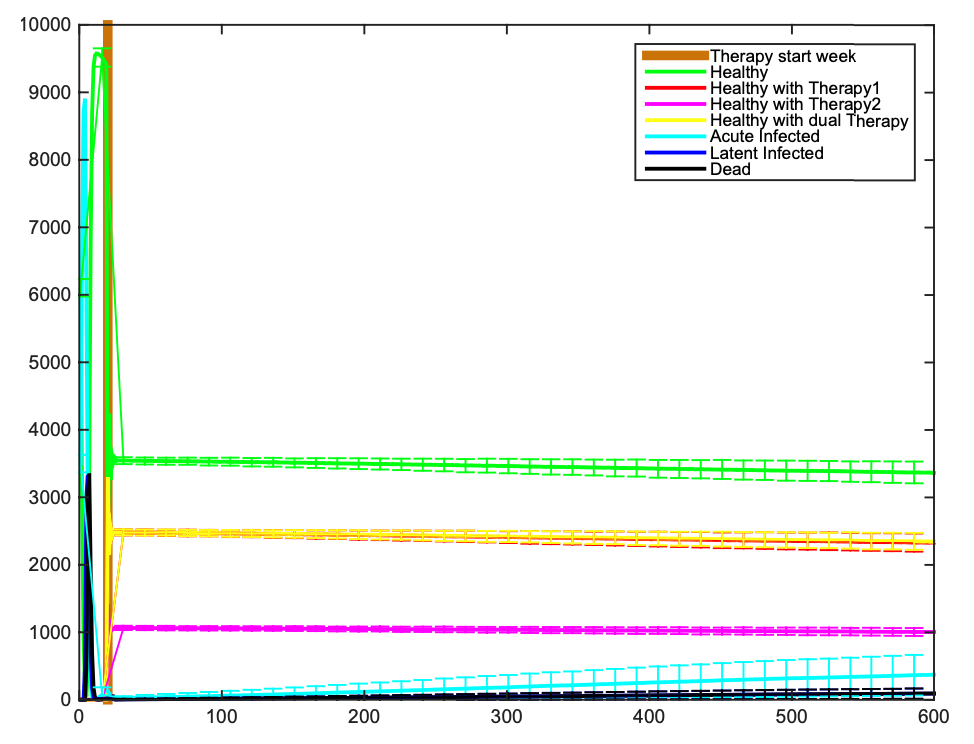

In [124]:
from IPython.display import Image
Image("ranaoriginal.png")

## Running the Model
Here we run the model 1000 times and record the cell counts as we go.

In [113]:
# Progress bar

import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 40
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [94]:
reps = 1000
counts = np.zeros([reps, 601, 7])
for run in range(reps):
    update_progress(run / reps)
    counts[run] = CA_SIM(100)
    update_progress((run + 1) / reps)

Progress: [########################################] 100.0%


## Plotting Results
In the cells below we compute the averages and plot our results.

In [ ]:
averages = np.array([[np.average(counts[:, t, i]) for i in range(7)] for t in range(601)])
stdev = np.array([[np.std(counts[:, t, i]) for i in range(7)] for t in range(601)])

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline

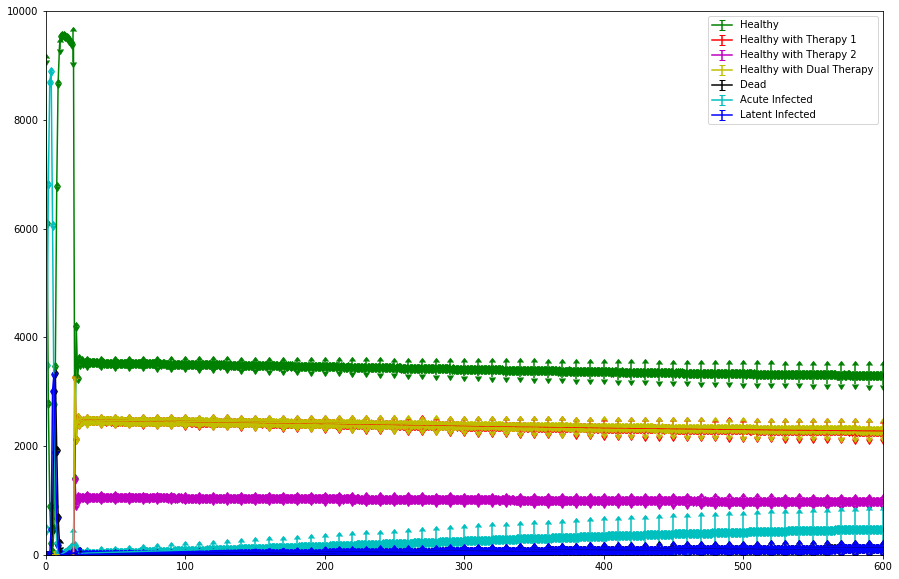

In [82]:
labels = ['Healthy', 'Healthy with Therapy 1', 'Healthy with Therapy 2', 'Healthy with Dual Therapy',
         'Dead', 'Acute Infected', 'Latent Infected']
cs = ['g', 'r', 'm', 'y', 'k', 'c', 'b']

plt.figure(figsize=(15,10))
for i in range(7):
    # In the figure below, we plot error bars once every 10 timesteps so the
    # plot is less cluttered
    stdev_plot = np.array([stdev[i,:] if i % 10 == 0 else np.zeros(7) for i in range(601)])
    plt.errorbar(range(601), averages[:,i], yerr=stdev_plot[:,i], 
                 uplims=True, lolims=True, label=labels[i], color=cs[i])

plt.legend(loc='upper right')
plt.ylim([0, 100**2])
plt.xlim([0, 600])
plt.show()

Comparing with the author's result, we see that the implementation is ***correct***.

# Save Movie
The sections below will export the saved frames of an example simulation into a movie. 

In [116]:
import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# With mac install ffmpeg with brew, $brew install ffmpeg
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'

In [117]:
states = [CELL_H, CELL_Ht1, CELL_Ht2, CELL_HtB, CELL_D, CELL_A1, CELL_A2]
cs = ['g', 'r', 'm', 'y', 'k', 'c', 'b']
mycmap = {k:list(map(lambda x : int(x * 255), matplotlib.colors.to_rgba(v))) for k, v in zip(states, cs)}


# labels = ['Healthy', 'Healthy with Therapy 1', 'Healthy with Therapy 2', 'Healthy with Dual Therapy',
#          'Dead', 'Acute Infected', 'Latent Infected']
labels = ['Healthy', 'H_t1', 'H_t2', 'H_tB', 'Dead', 'Acute', 'Latent']
names = {k:v for k, v in zip(states, labels)}

In [118]:
arr = []
for t in range(0,601):
    picture = np.load("rana_data/" + str(t) + '.npy')
    data = np.zeros((100,100,3), dtype=np.uint8)
    for row in range(0, len(data)):
            for col in range(0, len(data)):
                data[row, col] = mycmap[picture[row, col]][:3]
    arr.append(data)

In [119]:
import matplotlib.patches as mpatches

Progress: [########################################] 100.0%


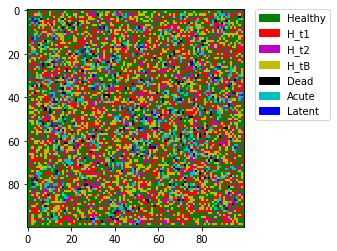

In [120]:
# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=2)

fig = plt.figure()
im = plt.imshow(arr[-1], animated=True)
# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(mycmap[k]) / 255, label=labels[i]) for i, k in enumerate(mycmap)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

def updatefig(frame, *args):
    update_progress(frame / 601)
    im.set_array(arr[frame])
    update_progress((frame + 1) / 601)
    return im,
ani = animation.FuncAnimation(fig, updatefig, frames=601, blit=True)
ani.save('../Animations/rana.mp4', writer=writer, dpi=196)